## Split Data & Encoding


In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Load the cleaned mental health data with risk labels
file_path = "aai-590-capstone-mental-health/data-assets/cleaned_mental_health_data.csv"
#file_path = "./data-assets/cleaned_mental_health_data.csv"
#file_path = "/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test-mental-health.csv"
df = pd.read_csv(file_path)
df.columns

Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options', 'risk_label'],
      dtype='object')

In [4]:
df.shape

(260986, 18)

In [5]:
# Drop the Timestamp column
df = df.drop(columns=["Timestamp"])

In [6]:
# Encode all object/categorical columns first (on full DataFrame)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
# Now split into train/test
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

### Clustering

In [8]:
!pip install kmodes --quiet
from kmodes.kmodes import KModes

In [9]:
# Set the number of clusters (e.g., 3 for low/medium/high risk)
n_clusters = 3

# Fit k-modes on training data only
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1, random_state=42)
train_clusters = km.fit_predict(X_train)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 65126, cost: 1339034.0
Run 1, iteration: 2/100, moves: 35360, cost: 1328062.0
Run 1, iteration: 3/100, moves: 7241, cost: 1328062.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 42824, cost: 1335311.0
Run 2, iteration: 2/100, moves: 72, cost: 1335311.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 57257, cost: 1314210.0
Run 3, iteration: 2/100, moves: 22041, cost: 1299806.0
Run 3, iteration: 3/100, moves: 21857, cost: 1280198.0
Run 3, iteration: 4/100, moves: 12716, cost: 1276606.0
Run 3, iteration: 5/100, moves: 2599, cost: 1276606.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 45252, cost: 1326749.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...


In [10]:
# Assign clusters to the test set using trained centroids
test_clusters = km.predict(X_test)

In [11]:
X_train['risk_label'] = train_clusters
X_test['risk_label'] = test_clusters

In [12]:
# For train data (interpretation/profiling)
for i in range(3):
    print(f"\n--- Cluster {i} (train) ---")
    display(X_train[X_train['risk_label'] == i].mode().iloc[0])


--- Cluster 0 (train) ---


,0
Gender,1
Country,9
Occupation,2
self_employed,0
family_history,1
treatment,1
Days_Indoors,0
Growing_Stress,1
Changes_Habits,0
Mental_Health_History,2



--- Cluster 1 (train) ---


,0
Gender,1
Country,9
Occupation,0
self_employed,0
family_history,0
treatment,0
Days_Indoors,1
Growing_Stress,0
Changes_Habits,2
Mental_Health_History,1



--- Cluster 2 (train) ---


,0
Gender,1
Country,9
Occupation,4
self_employed,0
family_history,0
treatment,0
Days_Indoors,3
Growing_Stress,2
Changes_Habits,1
Mental_Health_History,0


## Cluster Interpretations and Risk Labels (Based on Modal Values)

#### **Cluster 1 — High Risk**
This group exhibits the highest frequency of risk indicators, such as family history of mental health issues, prior treatment, high stress, mood swings, coping struggles, and social weakness. The concentration of "yes" responses across these features points to a high-risk profile.

#### **Cluster 0 — Medium Risk**
Individuals in this cluster show a moderate pattern: some evidence of mental health risk (e.g., mental health history, mood swings), but generally lower on coping struggles and social weakness compared to the high-risk cluster.

#### **Cluster 2 — Low Risk**
This cluster is characterized by the lowest occurrence of risk factors—most members have not sought treatment, lack a family history of mental illness, and do not report major struggles, aside from occasional mood swings or social weakness. Overall, this cluster represents the lowest mental health risk.


In [13]:
# Display the first few rows of the encoded X_train DataFrame
pd.set_option('display.max_columns', None)  # Show all columns
X_train.head()

,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options,risk_label
49716,0,9,2,0,0,1,3,0,2,1,2,0,1,1,1,1,1
238330,1,9,0,0,1,1,1,1,1,2,2,0,0,2,0,2,0
237747,1,8,1,0,0,0,1,2,0,2,2,0,0,0,0,0,1
128998,1,9,2,0,0,0,1,2,0,2,2,0,0,1,0,1,1
85957,1,9,3,0,0,0,2,1,2,2,2,0,1,1,1,1,1


In [14]:
# Assume you have X_train and cluster assignments as 'risk_label'
modal_table = pd.DataFrame([
    X_train[X_train['risk_label'] == i].mode().iloc[0]
    for i in sorted(X_train['risk_label'].unique())
])

# Drop the cluster label column
modal_table = modal_table.drop(columns=['risk_label'])

# Compute variance for each feature's mode across clusters
modal_variances = modal_table.var()

# Sort features by variance (descending)
defining_features = modal_variances.sort_values(ascending=False)
print(defining_features)

Occupation                 4.000000
Days_Indoors               2.333333
care_options               1.333333
Growing_Stress             1.000000
Mental_Health_History      1.000000
Mood_Swings                1.000000
Changes_Habits             1.000000
Social_Weakness            1.000000
treatment                  0.333333
Coping_Struggles           0.333333
Work_Interest              0.333333
family_history             0.333333
Country                    0.000000
Gender                     0.000000
self_employed              0.000000
mental_health_interview    0.000000
dtype: float64


> We excluded the five most cluster-defining features, **Occupation**, **Days_Indoors**, **care_options**, **Changes_Habits**, and **Social_Weakness**, from our predictive modeling. All five features reflect aspects of an individual’s social environment and lifestyle stability, which are critical drivers of mental health risk. Their removal allows us to test whether meaningful risk prediction is possible in scenarios where key social and lifestyle data is unavailable or incomplete, such as in remote assessments or datasets with privacy restrictions.


### EDA for Risk Labels
This is to understand the impact risk label has and how it looks within the training data.

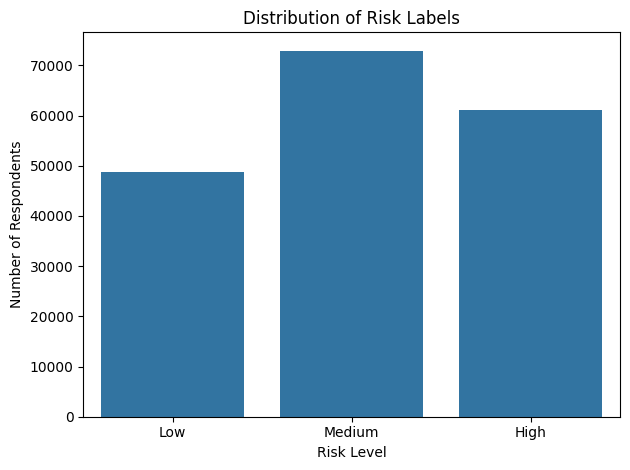

In [15]:
# Correct mapping based on your cluster interpretation
risk_label_map = {1: "High", 0: "Medium", 2: "Low"}

df_filtered = X_train.copy()
df_filtered['risk_label'] = df_filtered['risk_label'].map(risk_label_map)

sns.countplot(x='risk_label', data=df_filtered, order=["Low", "Medium", "High"])
plt.title("Distribution of Risk Labels")
plt.xlabel("Risk Level")
plt.ylabel("Number of Respondents")
plt.tight_layout()
plt.show()

### Bivariate Visuals

In [16]:
# Decode Country values using LabelEncoder
if 'Country' in label_encoders and df_filtered['Country'].dtype != 'object':
    df_filtered['Country'] = label_encoders['Country'].inverse_transform(
        df_filtered['Country'].astype(int)
    )

In [17]:
# Filter for top countries
top_countries = ['United States', 'United Kingdom', 'Canada']
df_top = df_filtered[df_filtered['Country'].isin(top_countries)].copy()

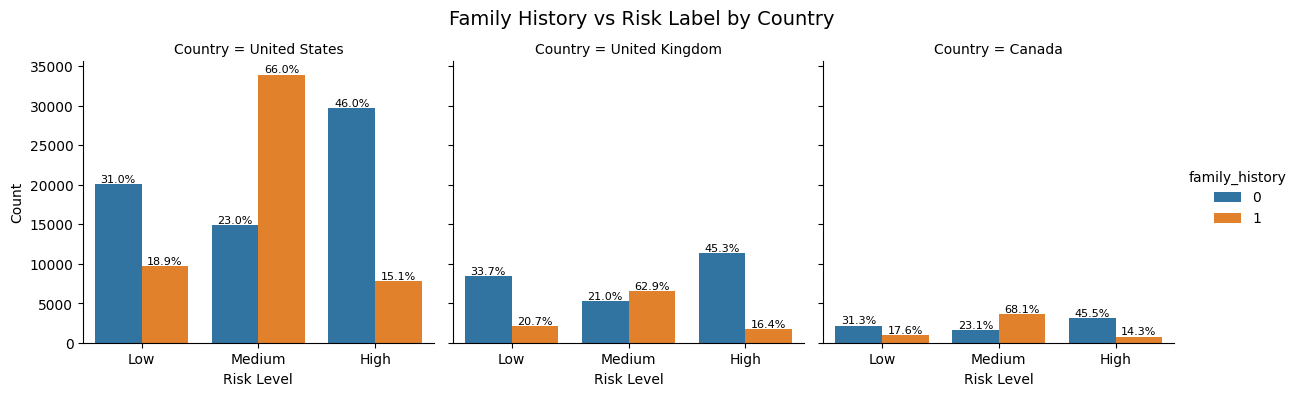

In [18]:
# Plot
g = sns.catplot(
    data=df_top,
    x='risk_label',
    hue='family_history',
    col='Country',
    kind='count',
    order=['Low', 'Medium', 'High'],
    col_wrap=3,
    height=4,
    aspect=1
)

# Add percentage labels
for ax in g.axes.flat:
    for c in ax.containers:
        heights = [b.get_height() for b in c]
        total = sum(heights)
        labels = [f'{(h / total * 100):.1f}%' if total > 0 else '' for h in heights]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Family History vs Risk Label by Country", fontsize=14)
g.set_axis_labels("Risk Level", "Count")
plt.show()

Across Canada, the U.K., and the U.S., individuals with a family history of mental illness (1) are consistently concentrated in the Medium-risk category. In contrast, those without family history (0) are more distributed across the Low and High-risk levels. This suggests that individuals who are aware of a family history may engage in earlier intervention or possess stronger coping strategies, leading to fewer extreme risk cases. Meanwhile, those without such awareness may miss early warning signs, reinforcing the importance of targeted education and outreach to this group.

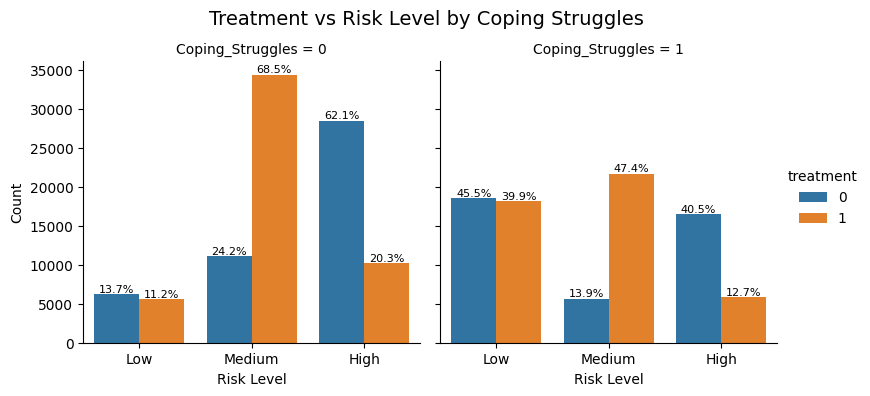

In [19]:
# Plot
g = sns.catplot(
    data=df_filtered,
    x='risk_label',
    hue='treatment',
    col='Coping_Struggles',
    kind='count',
    order=['Low', 'Medium', 'High'],
    height=4,
    aspect=1
)

# Percentage labels
for ax in g.axes.flat:
    for c in ax.containers:
        heights = [b.get_height() for b in c]
        total = sum(heights)
        labels = [f'{(h / total * 100):.1f}%' if total > 0 else '' for h in heights]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Treatment vs Risk Level by Coping Struggles", fontsize=14)
g.set_axis_labels("Risk Level", "Count")
plt.show()

Individuals without coping struggles who sought treatment were mostly in the Medium-risk group, suggesting early care may prevent escalation. Those untreated skewed High-risk. Among those with coping struggles, risk remained high regardless of treatment, implying treatment alone may not be enough without targeted coping support.

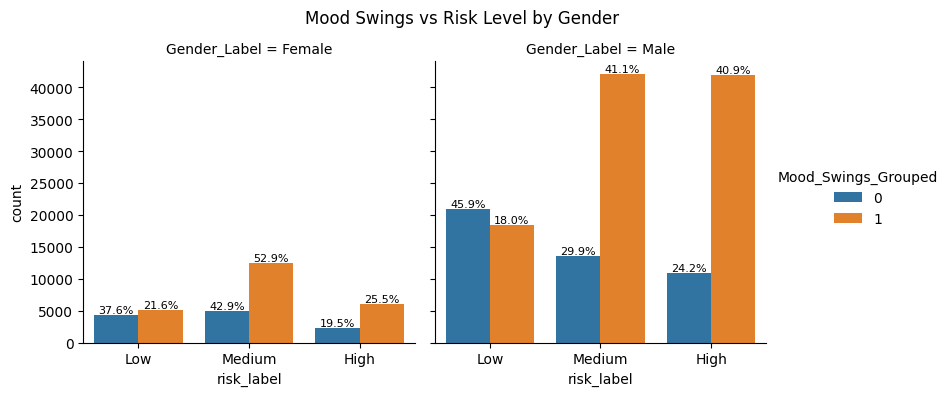

In [20]:
# Group Mood_Swings into binary
df_filtered['Mood_Swings_Grouped'] = df_filtered['Mood_Swings'].apply(lambda x: 0 if x == 0 else 1)
df_filtered['Gender_Label'] = df_filtered['Gender'].map({0: 'Female', 1: 'Male'})

# Plot
g = sns.catplot(
    data=df_filtered,
    x='risk_label',
    hue='Mood_Swings_Grouped',
    col='Gender_Label',
    kind='count',
    order=['Low', 'Medium', 'High'],
    height=4,
    aspect=1,
)

# Percentage labels
for ax in g.axes.flat:
    for c in ax.containers:
        total = sum([bar.get_height() for bar in c.patches])
        labels = [f'{(bar.get_height() / total) * 100:.1f}%' if bar.get_height() > 0 else '' for bar in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Mood Swings vs Risk Level by Gender")
plt.show()

Mood swings strongly predict higher mental health risk for both genders. Those reporting mood swings are far more likely to be in the Medium or High-risk groups, especially men. Without mood swings, individuals are more likely to fall into the Low-risk category, highlighting mood instability as a key early warning sign.

### Trivariate Visuals

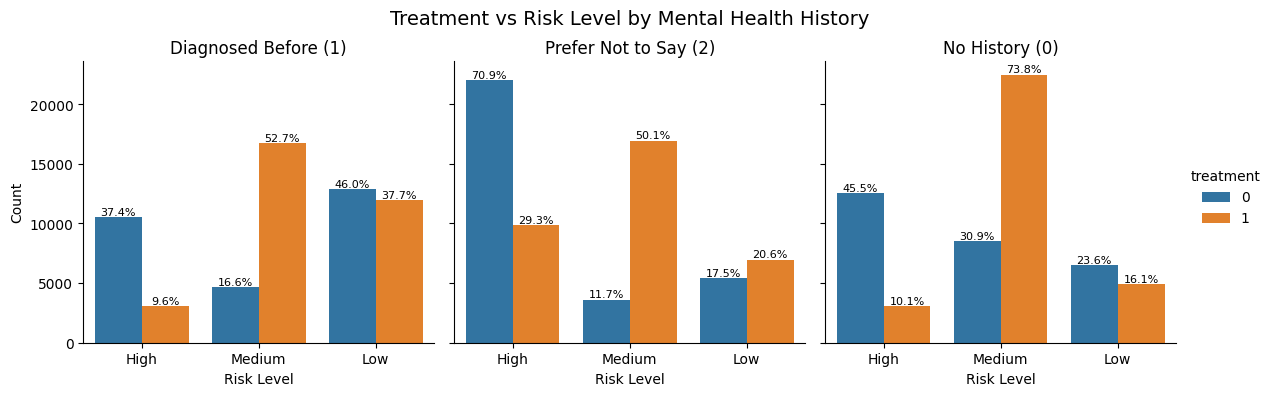

In [21]:
# Plot
g = sns.catplot(
    data=df_filtered,
    x='risk_label',
    hue='treatment',
    col='Mental_Health_History',
    kind='count',
    height=4,
    aspect=1
)

# Percentage labels
for ax in g.axes.flat:
    for c in ax.containers:
        total = sum([bar.get_height() for bar in c.patches])
        labels = [f'{(bar.get_height() / total) * 100:.1f}%' if total > 0 else '' for bar in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8)

# Set human-readable titles for each facet
titles = {
    0: "No History (0)",
    1: "Diagnosed Before (1)",
    2: "Prefer Not to Say (2)"
}
for ax, title in zip(g.axes.flat, df_filtered['Mental_Health_History'].unique()):
    ax.set_title(titles.get(title, f"Mental Health History = {title}"))

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Treatment vs Risk Level by Mental Health History", fontsize=14)
g.set_axis_labels("Risk Level", "Count")
plt.show()

This chart shows that those previously diagnosed and treated are mostly in the medium-risk group, suggesting treatment helps manage risk. In contrast, untreated individuals, especially those with no known history or who prefer not to say, are heavily concentrated in the high-risk group, revealing the importance of both early diagnosis and willingness to disclose.

                    Feature          Chi2
3            family_history  21328.811851
4                 treatment  16432.556959
8          Coping_Struggles  11163.999493
7               Mood_Swings   9015.641195
5            Growing_Stress   8160.884587
6     Mental_Health_History   5088.859057
9             Work_Interest   1816.304285
0                    Gender    439.426255
10  mental_health_interview     69.145687
2             self_employed     50.856562
1                   Country      7.440709


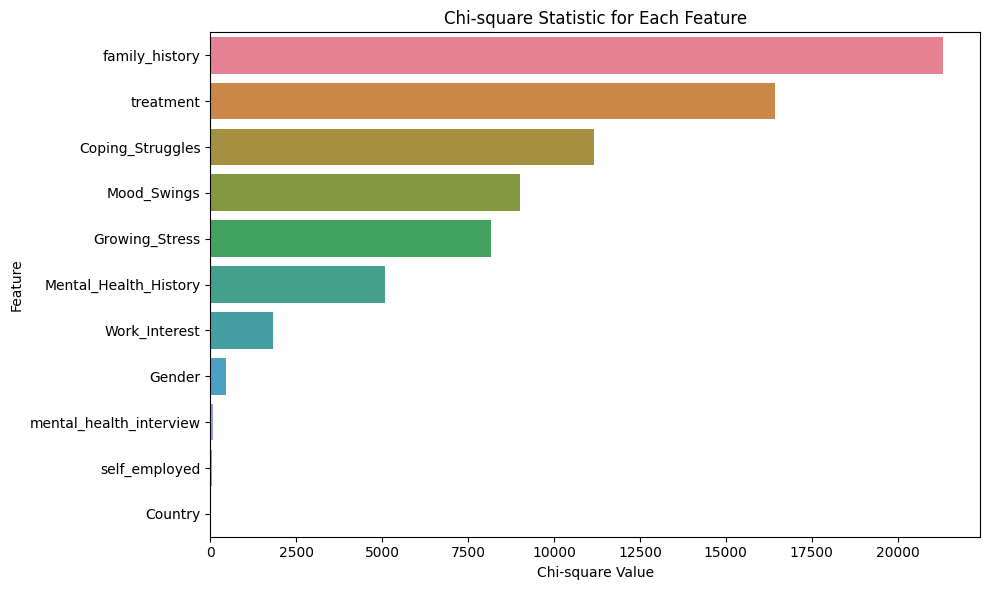

In [22]:
# Use the filtered list of categorical features
cat_features = [
    'Gender',
    'Country',
    'self_employed',
    'family_history',
    'treatment',
    'Growing_Stress',
    'Mental_Health_History',
    'Mood_Swings',
    'Coping_Struggles',
    'Work_Interest',
    'mental_health_interview'
]

# Encode categorical features for Chi-square
X = df_filtered[cat_features].apply(LabelEncoder().fit_transform)

# Encode risk_label as numeric
y = LabelEncoder().fit_transform(df_filtered['risk_label'])

# Chi-square feature selection
chi_scores = chi2(X, y)
chi_df = pd.DataFrame({'Feature': cat_features, 'Chi2': chi_scores[0]})
chi_df = chi_df.sort_values('Chi2', ascending=False)
print(chi_df)

# Generate a unique color for each feature
colors = sns.color_palette("husl", len(chi_df))

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Chi2',
    y='Feature',
    hue='Feature',
    data=chi_df,
    palette=colors,
    legend=False
)
plt.title("Chi-square Statistic for Each Feature")
plt.xlabel("Chi-square Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

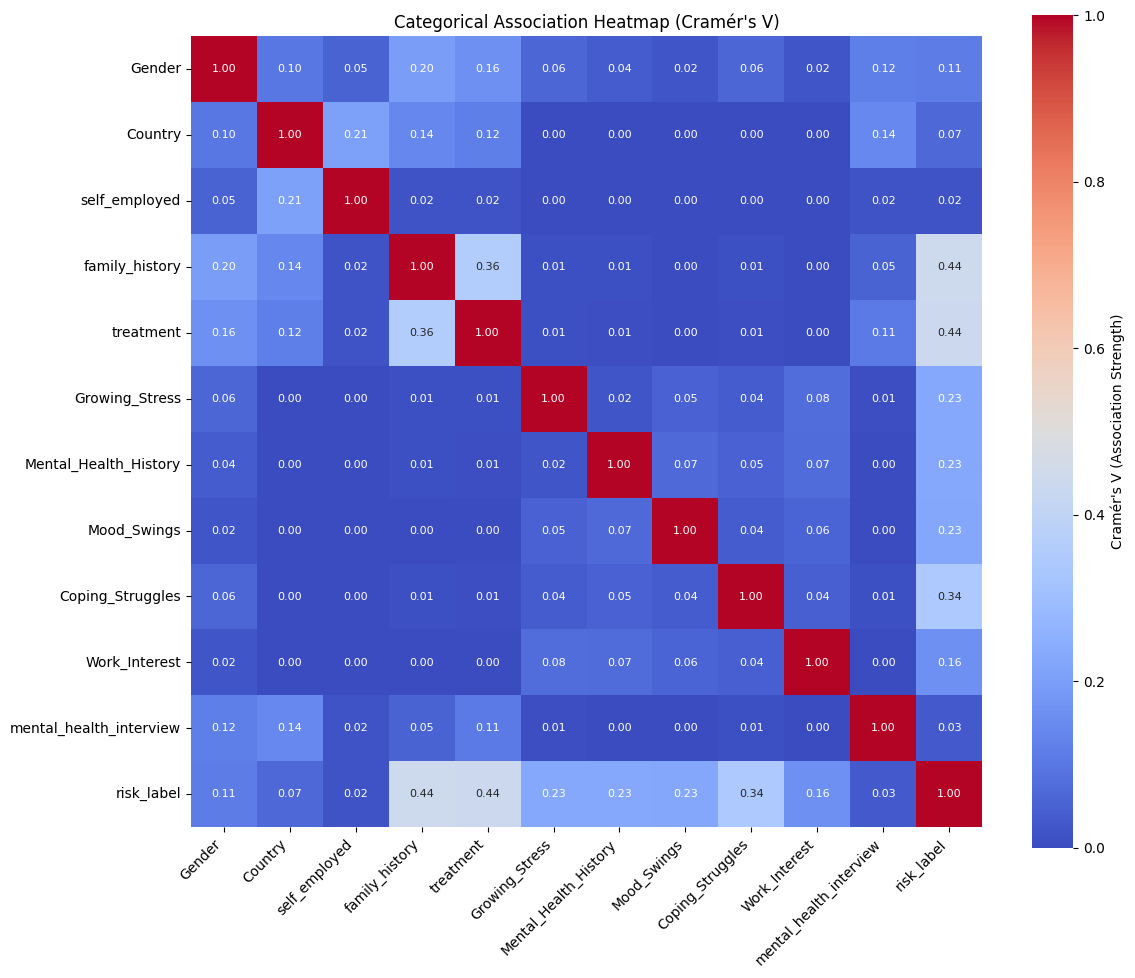

In [23]:
# Add risk_label if not in the list
if 'risk_label' not in cat_features:
    cat_features.append('risk_label')

# Make sure all columns are of 'category' dtype for the Cramér's V function
for col in cat_features:
    if col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].astype('category')

# Define Cramér’s V function with bias correction
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize an association matrix
assoc_matrix = pd.DataFrame(np.eye(len(cat_features)), index=cat_features, columns=cat_features)

# Fill the upper triangle of the matrix with Cramér’s V values
for i, col1 in enumerate(cat_features):
    for j, col2 in enumerate(cat_features):
        if i < j:
            value = cramers_v(df_filtered[col1], df_filtered[col2])
            assoc_matrix.loc[col1, col2] = value
            assoc_matrix.loc[col2, col1] = value

assoc_matrix = assoc_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    assoc_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
    annot_kws={"size": 8}, cbar_kws={'label': "Cramér's V (Association Strength)"}
)
plt.title("Categorical Association Heatmap (Cramér's V)")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

In [24]:
# Define y
y_train = X_train['risk_label']
y_test = X_test['risk_label']

# Define X (drop target + top 5 cluster features + 3 weakest Chi-square features)
features_to_remove = [
    'risk_label',             # Target variable
    # Top 5 most influential features from clustering
    'Occupation',
    'Days_Indoors',
    'care_options',
    'Changes_Habits',
    'Social_Weakness',
    # Bottom 3 Chi-square features
    'self_employed',
    'Country',
    'mental_health_interview'
]

X_train_model = X_train.drop(columns=features_to_remove)
X_test_model = X_test.drop(columns=features_to_remove)

# Check columns
print("Columns in X_train_model:")
X_train_model.columns.tolist()

Columns in X_train_model:


['Gender',
 'family_history',
 'treatment',
 'Growing_Stress',
 'Mental_Health_History',
 'Mood_Swings',
 'Coping_Struggles',
 'Work_Interest']

Removing the top 5 clustering features avoids label leakage, while dropping the 3 lowest chi-square features removes weak predictors. This simplifies the model, reduces noise, and improves generalization.

### Scaling

In [25]:
# Fit scaler on training data, then transform both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled = scaler.transform(X_test_model)

# If you want to keep it as a DataFrame with column names:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_model.columns, index=X_train_model.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_model.columns, index=X_test_model.index)

print("Scaling and normalization completed.")

Scaling and normalization completed.


In [38]:
#directory = "/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/"
directory = "aai-590-capstone-mental-health/data-assets/"

# Save unscaled feature sets (use for inverse scaling, plot raw values, feature importance)
X_train_model.to_csv(f"{directory}X_train.csv", index=False)
X_test_model.to_csv(f"{directory}X_test.csv", index=False)

# Save scaled feature sets
X_train_scaled.to_csv(f"{directory}X_train_encoded_scaled.csv", index=False)
X_test_scaled.to_csv(f"{directory}X_test_encoded_scaled.csv", index=False)

# Save target variables
pd.DataFrame(y_train).to_csv(f"{directory}y_train.csv", index=False)
pd.DataFrame(y_test).to_csv(f"{directory}y_test.csv", index=False)

print("All required files saved")

All required files saved


In [39]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (182690, 17)
X_test shape: (78296, 17)
X_train_scaled shape: (182690, 8)
X_test_scaled shape: (78296, 8)
y_train shape: (182690,)
y_test shape: (78296,)
